<a href="https://colab.research.google.com/github/harshddes/Quant-Research-Project---Harsh-Desai/blob/main/TB_MTQ_XGBoost_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

%matplotlib inline


In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

In [ ]:
df = pd.read_parquet('data.parquet')

print(df.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [ ]:
# Calculating the spread and other new columns using .loc to avoid SettingWithCopyWarning
df.loc[:, 'spread'] = df['banknifty'] - df['nifty']
df.loc[:, 'daily_returns'] = df['spread'].pct_change()
df.loc[:, 'ma7'] = df['spread'].rolling(window=7).mean()
df.loc[:, 'ma30'] = df['spread'].rolling(window=30).mean()
df.loc[:, 'volatility_30'] = df['daily_returns'].rolling(window=30).std()
df.loc[:, 'momentum'] = df['spread'] - df['ma7']

df.dropna(inplace=True)

df.loc[:, 'future_returns'] = df['daily_returns'].shift(-1)

df = df.iloc[:-1]

# Feature defination
X = df.loc[:, ['daily_returns', 'ma7', 'ma30', 'volatility_30', 'momentum']]
y = df.loc[:, 'future_returns']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training the XGBoost Model

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.0028976780812174667


In [ ]:
X_scaled = scaler.transform(X)

df['predicted_returns'] = xgb_model.predict(X_scaled)

# trading signals based on predicted returns
# Here, a simple strategy is used: go long if predicted returns are positive, go short if negative
df['signal'] = df['predicted_returns'].apply(lambda x: 1 if x > 0 else -1)

print(df[['predicted_returns', 'signal']].tail())


                     predicted_returns  signal
time                                          
2022-06-30 15:25:00           0.032587       1
2022-06-30 15:26:00          -0.004487      -1
2022-06-30 15:27:00           0.022471       1
2022-06-30 15:28:00           0.030127       1
2022-06-30 15:29:00          -0.005558      -1


P&L: 12758246.993396297
Sharpe Ratio: 0.17828753888185608
Maximum Drawdown: -0.09228264086850568


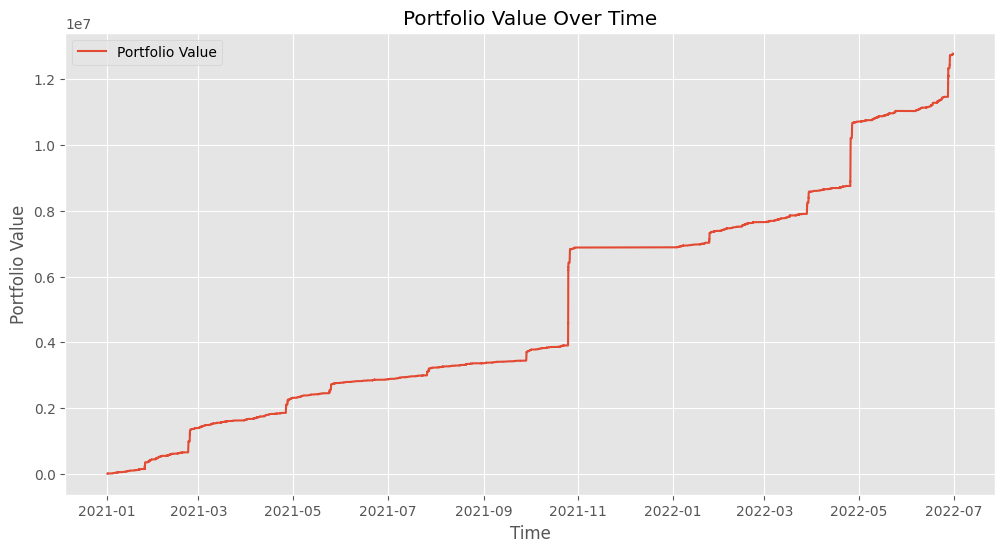

In [ ]:
initial_capital = 10000
df['position'] = df['signal']
df['position_change'] = df['position'].diff()
df['trade_returns'] = df['daily_returns'] * df['position'].shift()

df['portfolio_value'] = initial_capital + (df['trade_returns'].cumsum() * initial_capital)

final_portfolio_value = df['portfolio_value'].iloc[-1]
pnl = final_portfolio_value - initial_capital
print("P&L:", pnl)

risk_free_rate = 0.00
sharpe_ratio = (df['trade_returns'].mean() - risk_free_rate) / df['trade_returns'].std() * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio)

roll_max = df['portfolio_value'].cummax()
daily_drawdown = df['portfolio_value'] / roll_max - 1.0
max_drawdown = daily_drawdown.min()
print("Maximum Drawdown:", max_drawdown)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['portfolio_value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


In [ ]:
df['ma7'] = df['spread'].rolling(window=7).mean()
df['ma30'] = df['spread'].rolling(window=30).mean()
df['volatility_30'] = df['daily_returns'].rolling(window=30).std()
df['momentum'] = df['spread'] - df['ma7']

df['future_returns'] = df['daily_returns'].shift(-1)

df.dropna(inplace=True)

X = df[['daily_returns', 'ma7', 'ma30', 'volatility_30', 'momentum']]
y = df['future_returns']

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

tscv = TimeSeriesSplit(n_splits=5)

# Initializing an array to store the out-of-sample predictions
oos_predictions = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror'
    )
    model.fit(X_train_scaled, y_train)

    predictions = model.predict(X_test_scaled)
    oos_predictions.extend(predictions)

    mse = mean_squared_error(y_test, predictions)
    print(f'Test MSE: {mse}')

oos_predictions_df = pd.DataFrame(oos_predictions, index=X.index[-len(oos_predictions):], columns=['predicted_returns'])

df = df.join(oos_predictions_df, lsuffix='_actual', rsuffix='_predicted')



Test MSE: 0.00014610534155532916
Test MSE: 0.00014709176251886418
Test MSE: 0.24800462878500332
Test MSE: 0.00045755320614931184
Test MSE: 0.5354527173369398


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(X_train_scaled, y_train)

y_pred = best_xgb_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error with best parameters: ", mse)


Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error with best parameters:  0.03648052757143459
